In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import interpolate
from Classes.Domain import layer_p
from Classes.TypesInstant import RecordInfo
from Classes.ExtractSplice import ExtractSplice
from Classes.Func.DiagramsGen import PlotMain
from Classes.Func.KitTools import TimeShift, ConfigRead

In [2]:
file_name = r'C:\Users\HY_Burger\Desktop\Project\ExtubeWeanPrediction\prepare.csv'
data_loc = Path(ConfigRead('WaveData', 'Extube'))
vm_list = ['SPONT', 'CPAP', 'APNEA VENTILATION']
df_main = pd.read_csv(file_name)
df_main.endo_end = np.where(df_main.endo_end.str.contains('成功'), 0, 1)
TimeShift(df_main, ['endo_t', 'END_t', 'Resp_t'])
gp_main = df_main.groupby('PID')

In [3]:
def PatientGen(gp, pid):
    df = gp.get_group(pid)
    df = df.reset_index(drop=True)
    rid = df.Record_id.unique()[0]
    pid_obj = layer_p.Patient()
    pid_obj.pid = pid
    pid_obj.end_t = df.endo_t[0]
    pid_obj.end_i = df.endo_end.unique()[0]
    rid_p = RecordInfo(data_loc, pid_obj.end_t, rid)
    rid_p.ParametersInit()
    pid_obj.ridrec = rid_p.rec
    return pid_obj
def RecordGet(gp, pid):
    id_list = gp.get_group(pid).zdt_1.tolist()
    pid_obj = PatientGen(gp, pid)
    process_0 = ExtractSplice(pid_obj.ridrec)
    process_0.RecBatchesExtract(id_list, 1800)
    pid_obj.resp_l = process_0.RespSplicing(vm_list, 1800)
    return pid_obj.resp_l

In [4]:
# 1157905 3140128
resp_l = RecordGet(gp_main,2434879)
rr = np.array([i.rr for i in resp_l])
v_t = np.array([i.v_t_i for i in resp_l])
ve = np.array([i.ve for i in resp_l])
wob = np.array([i.wob for i in resp_l])
mp = np.array([i.mp_jl_t for i in resp_l])
wid_l = [round(i.wid) for i in resp_l]
t_ind = np.array([sum(wid_l[0:i])for i in range(len(wid_l))])
df = pd.DataFrame({'t_ind':t_ind,'rr':rr, 'v_t':v_t, 've':ve, 'wob':wob, 'mp':mp})
len(df)

487

## ReSample Processing

In [5]:
class FreqPreMethod():
    def __init__(self, time_array, target_array, range_=slice(None)):
        self.__time_a = time_array[range_]
        self.__target_a = target_array[range_]

    def __LenVertify(self):
        if not len(self.__time_a) == len(self.__target_a):
            print('Length Mismatch !')
            return

    def __SpaceGen(self, fs):
        ind_0 = self.__time_a.min()
        ind_1 = self.__time_a.max()
        ind_num = round((ind_1 - ind_0) * fs)
        array = np.linspace(ind_0, ind_1, ind_num, endpoint=False)
        array = np.around(array, decimals=2)
        return array

    def InitTimeSeries(self):
        self.__LenVertify()
        df = pd.DataFrame({'time': self.__time_a, 'value': self.__target_a})
        print('SIZE: ', len(df)) # xxxxx
        return df

    def Resampling(self, resample_rate):
        self.__LenVertify()
        f = interpolate.interp1d(self.__time_a, self.__target_a)
        array_x = self.__SpaceGen(resample_rate)
        array_y = f(array_x)
        df = pd.DataFrame({'time': array_x, 'value': array_y})
        print('SIZE: ', len(df)) # xxxxx
        return df

In [13]:
ind_sets = ['rr', 'v_t', 've', 'wob', 'mp']
T_sets = [1, 5, 10]
exp_set = [
    {'L': 15, 'resample_rate': 0.25},
    {'L': 30, 'resample_rate': 0.5},
    {'L': 60, 'resample_rate': 1},
    {'L': 120, 'resample_rate': 2},
    {'L': 240, 'resample_rate': 4}
]
exp_sel = exp_set[0]
ind_sel = ind_sets[0]
T_sel = T_sets[0]

## Interplot example 

SIZE:  487
Original


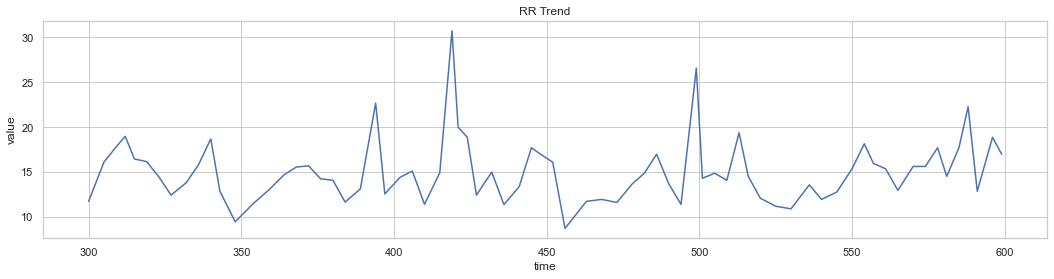

SIZE:  450
Resampling


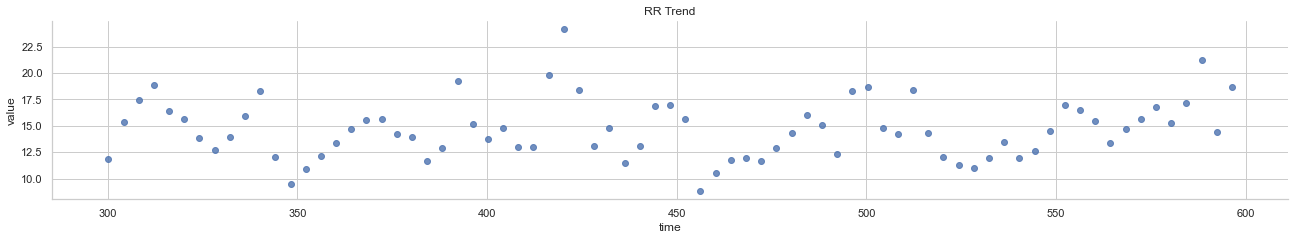

In [14]:
resp_clip = slice(100,200,1)
time_clip = lambda t1, t2, df: (df.time >= t1) & (df.time <= t2)
# rs_p = FreqPreMethod(df.t_ind, df[ind_sel], resp_clip)
rs_p = FreqPreMethod(df.t_ind, df[ind_sel])
pl_P = PlotMain()
df_raw = rs_p.InitTimeSeries()
print('Original')
pl_P.lineplot('time', 'value', df_raw[time_clip(300, 600, df_raw)], 'RR Trend')
df_rs = rs_p.Resampling(exp_sel['resample_rate'])
print('Resampling')
pl_P.lmplot('time', 'value', df_rs[time_clip(300, 600, df_rs)], 'RR Trend')

## PRSA Exp

In [15]:
L = exp_sel['L']
T = T_sel
arr_i = df_rs.value

anchor_s = []
anchor_ac = lambda x, y: True if np.mean(x[y:y + T]) > np.mean(x[y - T:y]) else False
anchor_dc = lambda x, y: True if np.mean(x[y:y + T]) < np.mean(x[y - T:y]) else False
anchor_set = anchor_dc

for i in range(L, len(arr_i) - L):
    if not anchor_set(arr_i, i):
            pass
    else:
        clip = slice(i - L, i + L + 1)
        anchor_s.append(arr_i[clip].tolist())
arr_prsa = np.array([np.mean(i) for i in np.array(anchor_s).T])
arr_axis = np.linspace(-L, L + 1, 2 * L + 1, endpoint=False)
df_prsa = pd.DataFrame({'axis': arr_axis, 'prsa': arr_prsa})

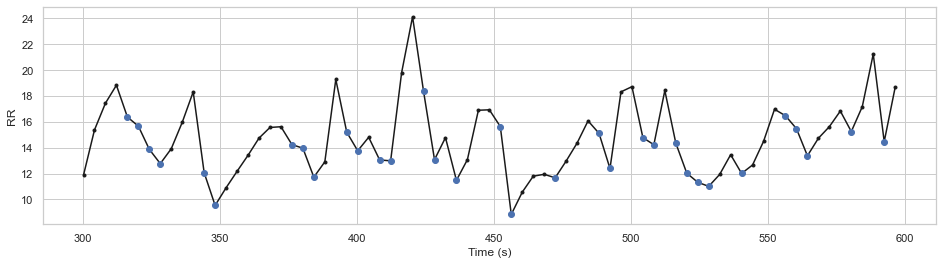

In [16]:
from matplotlib import pyplot as plt
df_anchor = df_rs.copy()
for i in range(L, len(df_rs) - L):
    if not anchor_set(df_rs.value, i):
        df_anchor.loc[i, 'anchor'] = False
    else:
        df_anchor.loc[i, 'anchor'] = True
df_anchor.anchor = df_anchor.anchor.fillna(False)
plt.figure(figsize=(16,4))
df_tmp = df_anchor[time_clip(300, 600, df_anchor)]
plt.xlabel('Time (s)')
plt.ylabel('{0}'.format(ind_sel.upper()))
plt.plot(df_tmp.time, df_tmp.value, 'k.-')
plt.plot(df_tmp[df_tmp.anchor==True].time, df_tmp[df_tmp.anchor==True].value, 'bo')
plt.show()

In [17]:
def ConsecCount(arr):
    dict_ = {}
    sequ = []
    for i in arr:
        if i:
            sequ.append(i)
        else:
            if not sequ:
                continue
            else:
                for j in range(len(sequ)):
                    if j + 1 in dict_.keys():
                        dict_[j + 1] += len(sequ) - j
                    else:
                        dict_[j + 1] = len(sequ) - j
                sequ = []
    return dict_
dict_ = ConsecCount(df_anchor.anchor)
print('Anchor total: {0}'.format(len(df_anchor[df_anchor.anchor].anchor)))
print('3 consecutive occurrences: {0}'.format(dict_[3]))
print('4 consecutive occurrences: {0}'.format(dict_[4]))
print('5 consecutive occurrences: {0}'.format(dict_[5]))

Anchor total: 191
3 consecutive occurrences: 17
4 consecutive occurrences: 5
5 consecutive occurrences: 1


In [18]:
# p_rep = df_anchor.groupby(df_anchor['anchor'].diff().ne(0).cumsum()).cumcount()
# print('3 consecutive occurrences: {0}'.format(len(p_rep[p_rep==3])))
# print('4 consecutive occurrences: {0}'.format(len(p_rep[p_rep==4])))
# print('5 consecutive occurrences: {0}'.format(len(p_rep[p_rep==5])))

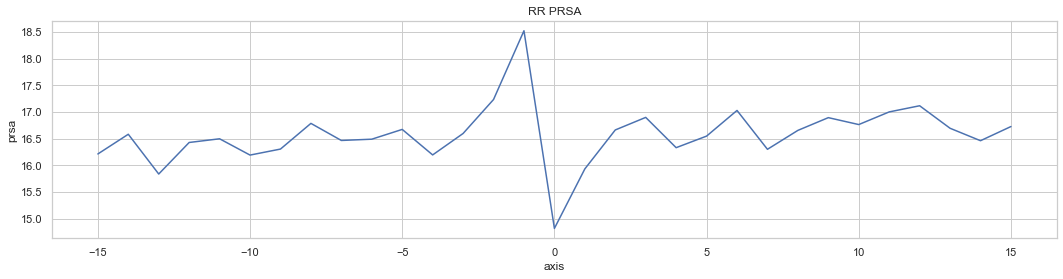

Anchor Length:  191


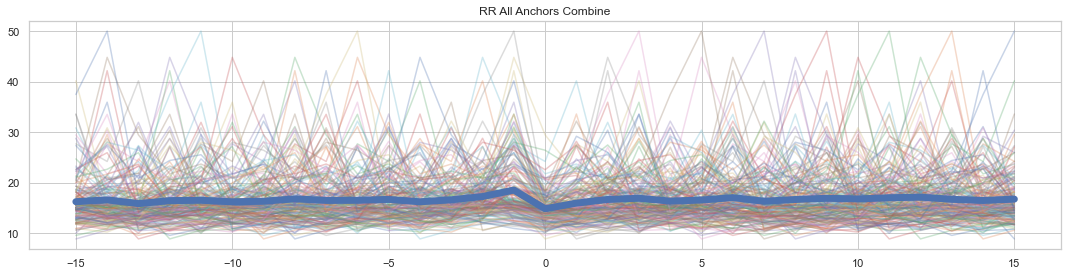

In [19]:
pl_P.lineplot('axis', 'prsa', df_prsa, '{0} PRSA'.format(ind_sel.upper()))
plt.figure(figsize=(15,4))
print('Anchor Length: ', len(anchor_s))
for i in anchor_s:
    plt.plot(arr_axis,i,alpha=0.3)
plt.plot(arr_axis, arr_prsa, c='b', label='y1',linewidth=7.0)
plt.title('{0} All Anchors Combine'.format(ind_sel.upper()))
plt.tight_layout()
plt.show()

In [20]:
def WaveletsAna(prsa_d,s):
    
    def __WtJudge( val):
        if val >= -1 and val < 0:
            para = -1 / 2
        elif val >= 0 and val < 1:
            para = 1 / 2
        else:
            para = 0
        return para

    df = prsa_d.copy()
    axis_s = np.linspace(-s, s, 2 * s, endpoint=False)
    prsa_s = df[df.axis.isin(axis_s)].prsa
    para_s = np.array([__WtJudge(i / s) for i in axis_s])
    value = np.sum(prsa_s * para_s / s)
    return round(value,3)
WaveletsAna(df_prsa, 2)

-1.251

## PYWT

In [12]:
# import pywt
# cA, cD = pywt.dwt(df_prsa.value, 'haar')
# plt.figure(figsize=(8,3))
# plt.plot(cD)
# plt.show()
# wave = pywt.idwt(cA, cD, wavelet='haar')
# plt.figure(figsize=(8,3))
# plt.plot(cA)
# plt.show()
